Could not load logo from GitHub: Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.. Using local image instead.


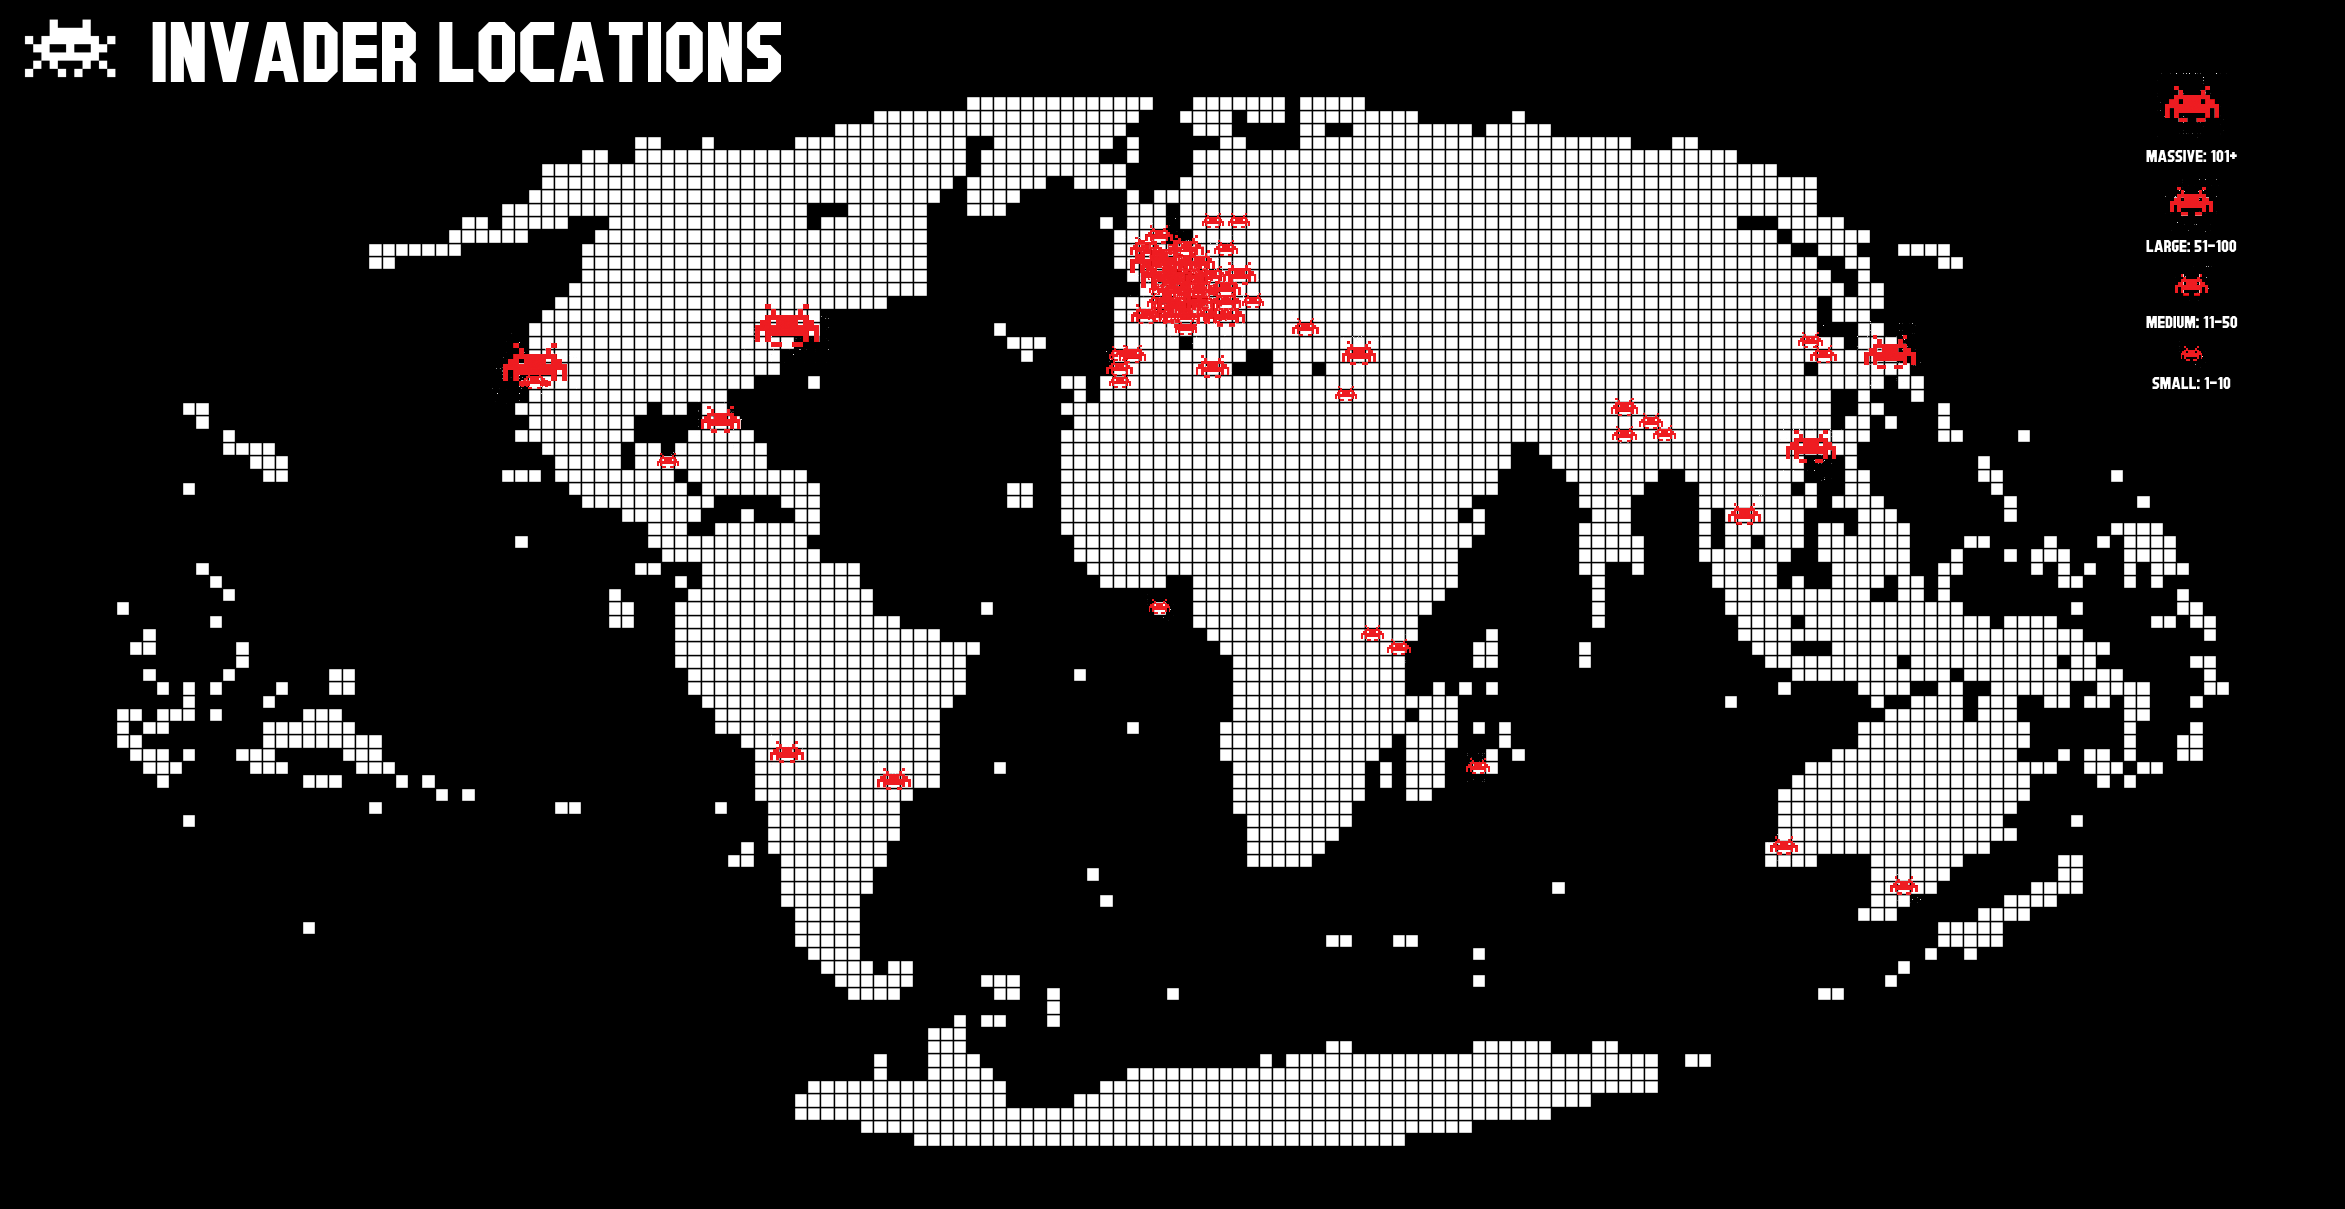

In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
import matplotlib.font_manager as fm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, AnchoredOffsetbox, VPacker, TextArea
from PIL import Image

# Fonts
title_font_path = r"C:\Users\higgsl\AppData\Local\Microsoft\Windows\Fonts\Signwood-vnvD7.ttf"
legend_font_path = r"C:\Users\higgsl\AppData\Local\Microsoft\Windows\Fonts\Signwood-vnvD7.ttf"
title_font = fm.FontProperties(fname=title_font_path)
legend_font = fm.FontProperties(fname=legend_font_path)

# Load shapefile
world_map = gpd.read_file("C:/Users/higgsl/Python Projects/Shapemaps/ne_10m_land.shp")
world_map = world_map.to_crs("ESRI:54009")

# Define grid size
grid_size = 225000
xmin, ymin, xmax, ymax = world_map.total_bounds
cols = np.arange(xmin, xmax, grid_size)
rows = np.arange(ymin, ymax, grid_size)
polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=world_map.crs)

# Intersect grid with land
land_union = world_map.geometry.union_all()
land_grid = grid[grid.intersects(land_union)].copy()

# Load city CSV
cities = pd.read_csv("C:/Users/higgsl/Python Projects/Datasets/invader_city_locations.csv")
cities_gdf = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.Longitude, cities.Latitude), crs="EPSG:4326")
cities_gdf = cities_gdf.to_crs("ESRI:54009")

# Spatial join
joined = gpd.sjoin(cities_gdf, land_grid, how="inner", predicate="within", lsuffix='left', rsuffix='right')
grid_counts = joined.groupby('index_right')['Count'].sum()
land_grid['Count'] = land_grid.index.map(grid_counts).fillna(0)

# Load and process invader image (remove white background)
img_path = "C:/Users/higgsl/Python Projects/Images/invader.png"
img = Image.open(img_path).convert("RGBA")
data = np.array(img)
data[(data[:, :, 0] > 240) & (data[:, :, 1] > 240) & (data[:, :, 2] > 240)] = [255, 255, 255, 0]
img_clean = Image.fromarray(data)
invader_img = np.array(img_clean)

# Function to create image with dynamic zoom
def get_image(img, count):
    zoom = 0.02 + min(count, 200) / 200 * 0.04  # scale based on count
    return OffsetImage(img, zoom=zoom)

# Plot map
fig, ax = plt.subplots(figsize=(30, 24))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# Plot land grid squares
land_grid.plot(ax=ax, color="white", edgecolor="black")

# Add invader icons
for idx, row in land_grid.iterrows():
    if row['Count'] > 0:
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
        ab = AnnotationBbox(get_image(invader_img, row['Count']), (x, y), frameon=False)
        ax.add_artist(ab)

# Remove axes
plt.axis("off")

# Title
title_text = "INVADER LOCATIONS"
title_fontsize = 60
ax.text(0.06, 1.02, title_text, fontproperties=pixel_font, color="white",
        fontsize=title_fontsize, transform=ax.transAxes, va='top', ha='left')

# Add invader image next to title (top-left)
# -------------------------------
# 11. Add logo from GitHub
logo_url = "https://raw.githubusercontent.com/TAFFETAPUNK/Assets/main/Images/invader_logo.png"
try:
    logo_img = mpimg.imread(logo_url)
except Exception as e:
    print(f"Could not load logo from GitHub: {e}. Using local image instead.")
    logo_img = mpimg.imread("C:/Users/higgsl/Python Projects/Images/invader_logo.png")

# Create inset axes inside the main plot
logo_ax = ax.inset_axes([0.001, 0.96, 0.05, 0.07])  # Inside plot area
logo_ax.imshow(logo_img)
logo_ax.set_facecolor("black")
logo_ax.axis("off")

# --- Legend with Four Invader Sizes (Top-Right) ---

# Function to create a scaled invader image for legend
def legend_invader_icon(img, zoom):
    return OffsetImage(img, zoom=zoom)

# Create legend items (icon + label)
legend_items = [
    (legend_invader_icon(invader_img, 0.05), "Massive: 101+"),
    (legend_invader_icon(invader_img, 0.04), "Large: 51–100"),
    (legend_invader_icon(invader_img, 0.03), "Medium: 11–50"),
    (legend_invader_icon(invader_img, 0.02), "Small: 1–10")
]

# Pack legend vertically
boxes = []
for icon, label in legend_items:
    text = TextArea(label, textprops=dict(color="white", fontproperties=legend_font, fontsize=12))
    item = VPacker(children=[icon, text], align="center", pad=0, sep=5)
    boxes.append(item)

# Final legend box (no title)
legend_box = VPacker(children=boxes, align="center", pad=5, sep=10)

# Anchor legend to top-right, slightly left
anchored_box = AnchoredOffsetbox(loc='upper right', child=legend_box, pad=0.5, frameon=True,
                                 bbox_to_anchor=(0.97, 1), bbox_transform=ax.transAxes, borderpad=1)
anchored_box.patch.set_facecolor("black")
anchored_box.patch.set_alpha(0.6)
ax.add_artist(anchored_box)

# Show plot
plt.show()